In [1]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import networkx as nx
from networkx.drawing.nx_agraph import write_dot
import pygraphviz

import json
import re
from pathlib import Path
from natsort import natsorted
from glob import glob

In [146]:
def edges2graph(lines, i2k=None, label2i=None):
    pattern = re.compile('"(.+)" -- "(.+)"')
    nodes = set()
    edges = set()
    for i,line in enumerate(lines):
        if len(line.strip()) > 0:
            edge = re.findall(pattern, line)[0]
            source, target = edge
            nodes.update([source, target])
            edges.add( (source, target) )
    
    if label2i is None:
        label2i = {k:i for i,k in enumerate(nodes)}
        i2k = list(range(len(nodes)))
    g = nx.Graph()
    
    nodes = [dict(id=label2i[k], label=k) for i,k in enumerate(nodes)]
    ids = [n['id'] for n in nodes]
    g.add_nodes_from( zip(ids, nodes) )
    
    edges = [(i2k[label2i[e[0]]],i2k[label2i[e[1]]]) for e in edges]
    g.add_edges_from(edges)
    return g, i2k, label2i


def read_graph(levels_dir):
    fns = natsorted(glob(f'{levels_dir}/*.txt'))
    level = len(fns)
    with open(fns[-1]) as f:
        g, i2k, label2i = edges2graph(f.readlines())
        for n in g.nodes:
            g.nodes[n]['level'] = level

        for e in g.edges:
            g.edges[e]['level'] = level

    for i,fn in enumerate(fns[:-1][::-1]):
        level -= 1
        with open(fn) as f:
            subgraph,_,_ = edges2graph(f.readlines(), i2k, label2i)
            for n in subgraph.nodes:
                g.nodes[n]['level'] = level
            for e in subgraph.edges:
                g.edges[e]['level'] = level
    return g
    
    
    
def read_js(fn_in, center=True, scale=1):
    data_in = {}
    with open(fn_in) as f0:
        for line in f0:
            if line.startswith('//'):
                continue
            var_name, value = line.split(' = ')
            value = value.strip()
#             value = re.sub(r'(\d+):', r'"\1":', value)
            
            try:
                value = json.loads(value)
            except json.JSONDecodeError as e:
                print(e)
                print(repr(value[e.colno-5:e.colno+20]))
                return e
            data_in[var_name] = value

    print(data_in.keys())

    ## centralize data
    if center:
        cx = sum(data_in['crd_x'].values()) / len(data_in['crd_x'])
        cy = sum(data_in['crd_y'].values()) / len(data_in['crd_y'])
        for k in data_in['crd_x']:
            data_in['crd_x'][k] -= cx
            data_in['crd_y'][k] -= cy
    if scale is not None:
        for k in data_in['crd_x']:
            data_in['crd_x'][k] *= scale
            data_in['crd_y'][k] *= scale
            
    return data_in

## topics large
# f = 'topics-large'
# fn_in = './in/topicslarge-BT.json'



# # alphanum_to_org = None
# # my_edges = data_in['my_edges']
# # label_to_id = data_in['label_to_id']
# id_to_label = data_in['id_to_label']
# # edge_distance = data_in['edge_distance']
# crd_x = data_in['crd_x']
# crd_y = data_in['crd_y']

In [169]:

def draw(g, pos, edges=True, labels=False, figsize=[8,8], s=2, lw=0.5):
    xy = np.array(list([pos[k] for k in g.nodes]))
    fig = plt.figure(figsize=figsize)
    ax = fig.subplots()
    
    ## nodes
    ax.scatter(xy[:,0], xy[:,1], s=s, zorder=3)
    
    ## edges
    if edges:
        lines = [[pos[i], pos[j]] for (i,j) in g.edges]
        lc = mc.LineCollection(lines, colors='grey', linewidths=lw)
        ax.add_collection(lc)
    ax.autoscale()
    ax.margins(0.1)
    plt.axis('equal')

    if labels:
        for i in g.nodes:
            plt.text(pos[i][0], pos[i][1], g.nodes[i]['label'])
    return ax

def update_coord(g, data):
    crd_x = data['crd_x']
    crd_y = data['crd_y']
    label_to_id = data.get('label_to_id', None)
    org_to_alphanum = data.get('org_to_alphanum', None)
    for n in g.nodes:
        node = g.nodes[n]
        full_label = node['label']
        if org_to_alphanum is None:
            short_label = full_label
        else:
            short_label = org_to_alphanum[full_label]
        
        node_id = str(label_to_id[short_label])
        
        x,y = crd_x[node_id], crd_y[node_id]
        node['pos'] = f'{x},{y}'
        node['weight'] = 0
    return g


In [199]:
# f = 'topics-DELG'
# fn_in = './in/topics-DELG.json'
# graph_dir = '../../zmlt/data/txt/topics_faryad_8level/'
# scale = 1

# f = 'lastfm-DELG'
# fn_in = './in/lastfm-DELG.json'
# graph_dir = '../../zmlt/data/txt/lastfm/'
# scale = 1

# f = 'tol-DELG'
# fn_in = './in/tol-DELG.json'
# graph_dir = '../../zmlt/data/txt/tol_graphs_8level/'
# scale = 1


# f = 'topics-CG'
# fn_in = './in/topics-CG.json'
# graph_dir = '../../zmlt/data/txt/topics_faryad_8level/'
# scale = 200

# f = 'lastfm-CG'
# fn_in = './in/lastfm-CG.json'
# graph_dir = '../../zmlt/data/txt/lastfm/'
# scale = 200

# f = 'tol-CG'
# fn_in = './in/tol-CG.json'
# graph_dir = '../../zmlt/data/txt/tol_graphs_8level/'
# scale = 200



# f = 'lastfm-BT'
# fn_in = './in/lastfm-BT.json'
# graph_dir = '../../zmlt/data/txt/lastfm/'
# scale = 1

f = 'topicslarge-BT'
fn_in = './in/topicslarge-BT.json'
graph_dir = '../../zmlt/data/txt/topics_large/'
scale = 10


g = read_graph(graph_dir)
data_in = read_js(fn_in, scale=scale)
G = update_coord(g, data_in)
for n in G.nodes(data=True):
    print(n)
    break

dict_keys(['my_edges', 'label_to_id', 'id_to_label', 'edge_distance', 'nodes_to_levels', 'crd_x', 'crd_y'])
(0, {'id': 0, 'label': 'noncommutative geometry', 'level': 7, 'pos': '-8337.810347925479,10527.400579383802', 'weight': 0})


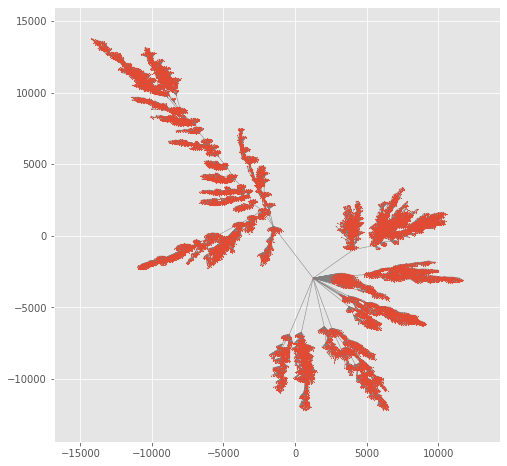

In [200]:
pos = {n:[float(x) for x in G.nodes[n]['pos'].split(',')] for n in G.nodes}
draw(G, pos, s=0.4)

In [112]:
# import numpy as np
# from matplotlib import collections as mc

# xy = np.array([(crd_x[k],crd_y[k]) for k in crd_x])
# fig = plt.figure(figsize=[12,12])
# ax = fig.subplots()
# # ax.scatter(xy[:,0], xy[:,1], s=1)

# lines = []
# linewidths = []
# for s,t in my_edges:
#     try:
#         source = (crd_x[str(label_to_id[s])], crd_y[str(label_to_id[s])])
#         target = (crd_x[str(label_to_id[t])], crd_y[str(label_to_id[t])])
#     except KeyError:
#         source = (crd_x[label_to_id[s]], crd_y[label_to_id[s]])
#         target = (crd_x[label_to_id[t]], crd_y[label_to_id[t]])
#     lines.append([source, target])
#     lw = (18-max(nodes_to_levels[s], nodes_to_levels[t]))/10
#     linewidths.append(lw)
# lc = mc.LineCollection(lines, linewidths=linewidths)
# ax.add_collection(lc)
# ax.autoscale()
# plt.show()

# Run this if need weights

In [ ]:
# gv = nx.Graph(pygraphviz.AGraph(
#     '../data/datasets/lastfm/dot/lastfmw_original.dot', strict=False, directed=False
# ))

# name_to_weight = {n['label'].replace('\\n', ' '): int(n['weight']) for i,n in gv.nodes(data=True)}
# name_to_weight

## Graph

In [57]:
# new_edges = []
# new_nodes = []
 
# for n in id_to_label:
#     data = {}
#     data['id'] = n
#     data['pos'] = str(crd_x[str(n)])+','+str(crd_y[str(n)])
#     label = id_to_label[n]
#     data['level'] = int(nodes_to_levels[label])
#     if alphanum_to_org is None:
#         data['label'] = label
#     else:
#         data['label'] = alphanum_to_org[label]
    
#     try:
#         data['weight'] = name_to_weight[label]
#     except:
# #         print(data['label'])
#         data['weight'] = 0
#     new_nodes.append((int(n), data))
                        
    

# max_level = 0
# for e in my_edges:
#     data = {}
#     node1 = int(label_to_id[e[0]])
#     node2 = int(label_to_id[e[1]])
#     level1 = nodes_to_levels[e[0]]
#     level2 = nodes_to_levels[e[1]]
#     if(level1>max_level):
#         max_level = level1
#     if(level2>max_level):
#         max_level=level2
#     data['level'] = max(level1, level2)
# #     data['level'] = 1
    
#     new_e = (node1, node2, data)
#     new_edges.append(new_e)


# G = nx.Graph()
# G.add_nodes_from(new_nodes)
# G.add_edges_from(new_edges)

# # print(max_level)
# # print(new_edges[10])
# # print(new_nodes[0])
# # print(new_edges[0])
# # print(len(new_nodes))  
# print(G.nodes[10])

NameError: name 'id_to_label' is not defined

In [ ]:
# xy = np.array([(crd_x[k],crd_y[k]) for k in crd_x])
# fig = plt.figure(figsize=[12,12])
# ax = fig.subplots()
# ax.scatter(xy[:,0], xy[:,1], s=1)

# lines = []
# linewidths = []
# for s,t in G.edges:
#     source = (crd_x[str(s)], crd_y[str(s)])
#     target = (crd_x[str(t)], crd_y[str(t)])
#     lines.append([source, target])
#     lw = (18-G.edges[t,s]['level'])/10
#     linewidths.append(lw)
# lc = mc.LineCollection(lines, linewidths=linewidths)
# ax.add_collection(lc)
# plt.show()

    

## generate map

In [201]:
f

'topicslarge-BT'

In [203]:
!mkdir {f}
!mkdir {f}/layers

mkdir: topicslarge-BT: File exists
mkdir: topicslarge-BT/layers: File exists


In [204]:
## write sub trees in the hierarchy
levels = sorted(set([ G.nodes[i]['level'] for i in G.nodes]))
for l in tqdm(levels):
    n = [i for i in G.nodes if G.nodes[i]['level'] <= l]
    sub = G.subgraph(n)
    write_dot(sub, f'{f}/layers/graph-{l}.dot')

  0%|          | 0/29 [00:00<?, ?it/s]

In [205]:
## read the underlying graph (not only trees)

import pygraphviz as pgv
if 'topics' in f and 'large' not in f:
    fn_graph = '../data/datasets/topics/orginal/Topics_Graph_Connected.dot'
    original = nx.Graph(pgv.AGraph(fn_graph))
        
elif 'lastfm' in f:
    fn_graph = '../data/datasets/lastfm/dot/lastfmw_original.dot'
    original = nx.Graph(pgv.AGraph(fn_graph))
    for n in original.nodes:
        original.nodes[n]['label'] = original.nodes[n]['label'].replace('\\n', ' ')
            
elif 'topicslarge' in f:
    ## TODO load original graph instead of trees
    original = G
elif 'tol' in f:
    original = G    


In [ ]:
# query = 'inversion'

# for s,t in original.edges:
#     l1, l2 = original.nodes[s]['label'], original.nodes[t]['label']
#     if query in l1 or query in l2:
#         print(l1,'----', l2)

In [206]:
o2label = {o:original.nodes[o]['label'] for o in original.nodes}
label2id = {G.nodes[i]['label']:i for i in G.nodes}

# print(set(o2label.values()) - set(label2id.keys()))
# print(set(label2id.keys()) - set(o2label.values()))

o2id = {o: label2id[o2label[o]] for o in original.nodes if o2label[o] in label2id}
# o2id


G0 = G.copy()
for n0,n1 in original.edges:
    if n0 in o2id and n1 in o2id:
        n0,n1 = o2id[n0], o2id[n1]
        if (n0,n1) not in G.edges:
            G0.add_edge(n0, n1)

In [207]:
write_dot(G0, "graph.dot")
write_dot(G, "tree.dot")

print(f)
!./mapgenerator.sh tree.dot
!mv out2 out3 map.svg graph.dot tree.dot {f}/

topicslarge-BT


## Geojson

In [208]:
dir_in = f'./{f}'
dir_out = f'../visualization_system/geojson/{f}'
print(dir_in)
print(dir_out)
if not Path(dir_out).exists():
    !mkdir {dir_out}
else:
    print(f'[warning] {dir_out} exists, may replace files there')
    


./topicslarge-BT
../visualization_system/geojson/topicslarge-BT
[warning] ../visualization_system/geojson/topicslarge-BT exists, may replace files there


In [209]:
%%time

!python ../geojson_generator/svg_to_geojson-mw.py {dir_in} {dir_out}

['./topicslarge-BT/layers/graph-1.dot', './topicslarge-BT/layers/graph-2.dot', './topicslarge-BT/layers/graph-3.dot', './topicslarge-BT/layers/graph-4.dot', './topicslarge-BT/layers/graph-5.dot', './topicslarge-BT/layers/graph-6.dot', './topicslarge-BT/layers/graph-7.dot', './topicslarge-BT/layers/graph-8.dot', './topicslarge-BT/layers/graph-9.dot', './topicslarge-BT/layers/graph-10.dot', './topicslarge-BT/layers/graph-11.dot', './topicslarge-BT/layers/graph-12.dot', './topicslarge-BT/layers/graph-13.dot', './topicslarge-BT/layers/graph-14.dot', './topicslarge-BT/layers/graph-15.dot', './topicslarge-BT/layers/graph-16.dot', './topicslarge-BT/layers/graph-17.dot', './topicslarge-BT/layers/graph-18.dot', './topicslarge-BT/layers/graph-19.dot', './topicslarge-BT/layers/graph-20.dot', './topicslarge-BT/layers/graph-21.dot', './topicslarge-BT/layers/graph-22.dot', './topicslarge-BT/layers/graph-23.dot', './topicslarge-BT/layers/graph-24.dot', './topicslarge-BT/layers/graph-25.dot', './topic

---

## Not used

In [ ]:


G_graphml = nx.readwrite.graphml.read_graphml("/Users/shiny/Downloads/output_Layer_8.graphml")


In [ ]:
print(len(G_graphml.edges()))

In [ ]:
# options = {
#     'node_color': 'black',
#     'node_size': 10,
#     'width': 3,
# }
# nx.draw(G_graphml, **options)

In [ ]:
write_dot(G_graphml, "direct_lastfm_8.dot")

# Get by level

In [ ]:
#Graph_2500.txt	Graph_4000.txt	Graph_500.txt


In [ ]:
f = open("data/datasets/refined/topics_faryad/Graph_500.txt",'r')

lines = f.read().split("\n")

In [ ]:
nodes = []
edges = []

for l in lines[:-1]:
    v = l.split(" -- ")
    v[0] = v[0].decode('utf-8', 'ignore')
    v[1] = v[1].decode('utf-8', 'ignore')
    edges.append([v[0],v[1]])
    if(v[0] not in nodes):
        nodes.append(v[0])
    if(v[1] not in nodes):
        nodes.append(v[1])

In [ ]:
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# options = {
#     'node_color': 'black',
#     'node_size': 10,
#     'width': 3,
# }
# nx.draw(G, **options)

In [ ]:
# nx.readwrite.gml.write_gml(G, 'Direct1.gml')
write_dot(G, "direct_500.dot")

In [ ]:

Name: 
Type: Graph
Number of nodes: 51
Number of edges: 50
Average degree:   1.9608

removed crossings: 0
CR: 0
UE: 0.37
ST: 91.751
NP: 0.821
lblbb: 9.69E+04
lblarea: 37.56406055
BB: (2242.3176734383565, 1623.5170672526447)
lblo: 0

    
    
Type: Graph
Number of nodes: 201
Number of edges: 200
Average degree:   1.9900

removed crossings: 0
CR: 0
UE: 0.442
ST: 1593.992
NP: 0.76
lblbb: 8.05E+04
lblarea: 155.60089481999992
BB: (4415.768665540002, 2837.6732704034766)
lblo: 0

    
Name: 
Type: Graph
Number of nodes: 801
Number of edges: 800
Average degree:   1.9975

removed crossings: 0
CR: 0
UE: 1.255
ST: 71405.377
NP: 0.63
lblbb: 7.88E+04
lblarea: 600.0002425200001
BB: (8665.419498448602, 5452.989729410348)
lblo: 0
    
Name: 
Type: Graph
Number of nodes: 1601
Number of edges: 1600
Average degree:   1.9988

removed crossings: 0
CR: 0
UE: 1.638
ST: 334792.295
NP: 0.592
lblbb: 1.02E+05
lblarea: 1206.3703762099988
BB: (14567.582911387577, 8432.250711921391)
lblo: 0

Name: 
Type: Graph
Number of nodes: 2001
Number of edges: 2000
Average degree:   1.9990

removed crossings: 0
CR: 0
UE: 1.838
ST: 649737.963
NP: 0.576
lblbb: 1.10E+05
lblarea: 1523.7907976600004
BB: (9766.49319786187, 17150.25697759996)
lblo: 0
    
Name: 
Type: Graph
Number of nodes: 3501
Number of edges: 3500
Average degree:   1.9994

removed crossings: 0
CR: 0
UE: 2.545
ST: 2165529.984
NP: 0.546
lblbb: 1.36E+05
lblarea: 2722.066423040002
BB: (16462.618508691055, 22528.635143834686)
lblo: 0

Name: 
Type: Graph
Number of nodes: 3001
Number of edges: 3000
Average degree:   1.9993

removed crossings: 0
CR: 0
UE: 1.977
ST: 1500728.222
NP: 0.547
lblbb: 9.96E+04
lblarea: 2319.083499429999
BB: (17906.197314446596, 12903.30155548481)
lblo: 0
    
Type: Graph
Number of nodes: 4001
Number of edges: 4000
Average degree:   1.9995

removed crossings: 0
CR: 0
UE: 2.362
ST: 2822522.585
NP: 0.54
lblbb: 1.68E+05
lblarea: 3125.864228509995
BB: (24107.333500323628, 21813.757616844523)
lblo: 0
    
Name: All
Type: Graph
Number of nodes: 5001
Number of edges: 5000
Average degree:   1.9996

removed crossings: 0
CR: 0
UE: 1.93
ST: 3465256.488
NP: 0.52
lblbb: 1.26E+05
lblarea: 5584.09027056
BB: (25389.882737441407, 27638.560192320983)
lblo: 0
    
    
    

Paper notes: Fix so all properties are same parts of speech

Space utilization -> compactness


